## How to combine fine-tuning and inference

Inference:

- One forward pass
- Intermediate tensors are deleted

Fine-tuning:

- Forward and backward pass
- Intermediate tensors are kept in context for backward pass
- During backward pass, gradients wrt outputs and weights are computed

Consider a linear layer without bias. `W.shape = [in, out]`

`input_grad` and `input_nograd` are parts of tensor for fine-tuning and inference

`input_grad.shape = [B_grad, in]`, `input_nograd.shape = [B_nograd, in]`

Forward computes:

- `input_grad @ W`
- `input_nograd @ W`
- `input_grad` is saved to context

Backward takes `d loss / d output_grad` computes:

- `d loss / d input_grad` using `W`
- `d loss / d W` using `input_grad` if `W` is trainable

Therefore, saving `input_grad` during forward pass is not neeeded

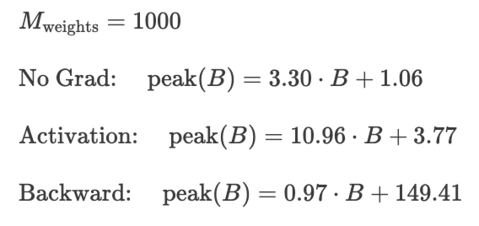
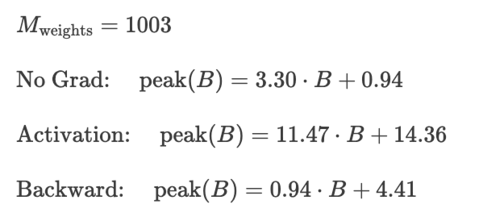

Let's try to implement custom linear that computes grad and nograd in parallel.

Baseline: sequential execution for grad in no-grad

In [1]:
import torch
import torch.nn as nn
import os
import time
import threading
import subprocess
from contextlib import contextmanager
from pynvml import *
from time import sleep
from dataclasses import dataclass
import gc
from multilora.benchmarking import monitor_gpu_memory_smi

/mnt/home/surkov/conda_envs/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
in_features = 10000
out_features = 10000

linear_base = nn.Linear(in_features=in_features, out_features=out_features, bias=False).cuda()
linear_mixed = ...

def no_grad(module, batch):
    with torch.no_grad():
        result = module(batch)

def grad(module, batch):
    result = module(batch)

def backward(module, batch):
    result = module(batch)
    result.sum().backward()

def experiment(module, func, batch):
    module.zero_grad()
    with monitor_gpu_memory_smi(interval=0.01) as measurement:
        func(module, batch)
    return measurement

In [4]:
batch_size = 5000
batch = torch.rand(batch_size, in_features, device="cuda")
print(
    experiment(linear_base, no_grad, batch)
)

                |      Start |     Finish |       Peak
-------------------------------------------------------
      Allocated |        572 |        580 |        771
       Reserved |        574 |        786 |        786
          Total |        882 |       1104 |       1104


In [34]:
class MixedLinearFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input_grad, input_nograd, weight):
        ctx.save_for_backward(input_grad, weight)
        output_grad = input_grad @ weight
        with torch.no_grad():
            output_nograd = input_nograd @ weight
        return output_grad, (output_nograd,)
    
    @staticmethod
    def backward(ctx, grad_output, _):
        input, weight = ctx.saved_tensors
        assert _ is None, "The second grad_output should be None because output_nograd requires no grad"
        
        grad_input = grad_output @ weight.T
        grad_weight = input.transpose(1, 2) @ grad_output
        grad_weight = grad_weight.sum(dim=0)
        
        return grad_input, None, grad_weight

class MixedLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super(MixedLinear, self).__init__()
        self.weight = nn.Parameter(torch.randn(in_features, out_features))
        
    def forward(self, input_grad, input_nograd):
        return MixedLinearFunction.apply(input_grad, input_nograd, self.weight)

# Example usage
in_features = 5
out_features = 6
linear = nn.Linear(in_features=in_features, out_features=out_features, bias=False)
mlinear = MixedLinear(in_features=in_features, out_features=out_features)
linear.weight.data = mlinear.weight.data.T.clone()

input1 = torch.rand((3, 4, in_features))
input2 = torch.rand((3, 4, in_features))

out_grad, (out_nograd,) = mlinear(input1, input2)
out_grad.sum().backward()

out_grad1, out_nograd1 = linear(input1), linear(input2)

assert torch.allclose(out_nograd1, out_nograd, 1e-3, 1e-3)
assert torch.allclose(out_grad1, out_grad, 1e-3, 1e-3)


NameError: name 'nn' is not defined

In [1]:
import torch
import triton
import triton.language as tl
import gc


@triton.autotune(
    configs=[
        triton.Config({'BLOCK_M': 32,  'BLOCK_N': 32,  'BLOCK_K': 32},  num_warps=2),
        triton.Config({'BLOCK_M': 64,  'BLOCK_N': 64,  'BLOCK_K': 32},  num_warps=4),
        triton.Config({'BLOCK_M': 64,  'BLOCK_N': 128, 'BLOCK_K': 32},  num_warps=4),
        triton.Config({'BLOCK_M': 128, 'BLOCK_N': 64,  'BLOCK_K': 32},  num_warps=4),
        triton.Config({'BLOCK_M': 128, 'BLOCK_N': 128, 'BLOCK_K': 32},  num_warps=8),
        triton.Config({'BLOCK_M': 32,  'BLOCK_N': 64,  'BLOCK_K': 64},  num_warps=2),
        triton.Config({'BLOCK_M': 64,  'BLOCK_N': 32,  'BLOCK_K': 64},  num_warps=2),
        triton.Config({'BLOCK_M': 64,  'BLOCK_N': 64,  'BLOCK_K': 64},  num_warps=4),
        triton.Config({'BLOCK_M': 128, 'BLOCK_N': 64,  'BLOCK_K': 64},  num_warps=4),
        triton.Config({'BLOCK_M': 64,  'BLOCK_N': 128, 'BLOCK_K': 64},  num_warps=4),
        triton.Config({'BLOCK_M': 128, 'BLOCK_N': 128, 'BLOCK_K': 64},  num_warps=8),
        triton.Config({'BLOCK_M': 64,  'BLOCK_N': 64,  'BLOCK_K': 128}, num_warps=4),
        triton.Config({'BLOCK_M': 128, 'BLOCK_N': 64,  'BLOCK_K': 128}, num_warps=4),
        triton.Config({'BLOCK_M': 64,  'BLOCK_N': 128, 'BLOCK_K': 128}, num_warps=4),
        triton.Config({'BLOCK_M': 128, 'BLOCK_N': 128, 'BLOCK_K': 128}, num_warps=8),
    ],
    key=['M1', 'M2', 'N', 'K'],  # dimensions that affect performance
)
@triton.jit
def mixed_matmul(
    input1_ptr, input2_ptr, weight_ptr, output1_ptr, output2_ptr,
    M1, M2, N, K,
    stride_in1_m, stride_in1_k,
    stride_in2_m, stride_in2_k,
    stride_w_n, stride_w_k,
    stride_out1_m, stride_out1_n,
    stride_out2_m, stride_out2_n,
    BLOCK_M: tl.constexpr,
    BLOCK_N: tl.constexpr,
    BLOCK_K: tl.constexpr,
):
    pid_m = tl.program_id(0)
    pid_n = tl.program_id(1)

    Np1 = (M1 + BLOCK_M - 1) // BLOCK_M
    Np2 = (M2 + BLOCK_M - 1) // BLOCK_M

    offs_m = tl.arange(0, BLOCK_M)
    offs_n = tl.arange(0, BLOCK_N)
    offs_k = tl.arange(0, BLOCK_K)

    if pid_m < Np1:
        row = pid_m * BLOCK_M + offs_m
        col = pid_n * BLOCK_N + offs_n

        input_block_ptr = input1_ptr + row[:, None] * stride_in1_m + offs_k[None, :] * stride_in1_k
        weight_block_ptr = weight_ptr + col[None, :] * stride_w_n + offs_k[:, None] * stride_w_k

        acc = tl.zeros((BLOCK_M, BLOCK_N), dtype=tl.float32)

        for k in range(0, K, BLOCK_K):
            a = tl.load(input_block_ptr, mask=(row[:, None] < M1) & (offs_k[None, :] + k < K), other=0.0)
            b = tl.load(weight_block_ptr, mask=(offs_k[:, None] + k < K) & (col[None, :] < N), other=0.0)
            acc += tl.dot(a, b)
            input_block_ptr += BLOCK_K * stride_in1_k
            weight_block_ptr += BLOCK_K * stride_w_k

        output_ptr = output1_ptr + row[:, None] * stride_out1_m + col[None, :] * stride_out1_n
        tl.store(output_ptr, acc, mask=(row[:, None] < M1) & (col[None, :] < N))

    elif pid_m < Np1 + Np2:
        pid_m_adjusted = pid_m - Np1
        row = pid_m_adjusted * BLOCK_M + offs_m
        col = pid_n * BLOCK_N + offs_n

        input_block_ptr = input2_ptr + row[:, None] * stride_in2_m + offs_k[None, :] * stride_in2_k
        weight_block_ptr = weight_ptr + col[None, :] * stride_w_n + offs_k[:, None] * stride_w_k

        acc = tl.zeros((BLOCK_M, BLOCK_N), dtype=tl.float32)

        for k in range(0, K, BLOCK_K):
            a = tl.load(input_block_ptr, mask=(row[:, None] < M2) & (offs_k[None, :] + k < K), other=0.0)
            b = tl.load(weight_block_ptr, mask=(offs_k[:, None] + k < K) & (col[None, :] < N), other=0.0)
            acc += tl.dot(a, b)
            input_block_ptr += BLOCK_K * stride_in2_k
            weight_block_ptr += BLOCK_K * stride_w_k

        output_ptr = output2_ptr + row[:, None] * stride_out2_m + col[None, :] * stride_out2_n
        tl.store(output_ptr, acc, mask=(row[:, None] < M2) & (col[None, :] < N))

# Example usage (Python side)
def call_mixed_matmul(input1, input2, weight):
    M1, K = input1.shape
    M2, _ = input2.shape
    N, _ = weight.shape

    output1 = torch.empty((M1, N), device=input1.device, dtype=input1.dtype)
    output2 = torch.empty((M2, N), device=input2.device, dtype=input2.dtype)

    grid = (triton.cdiv(M1, 64) + triton.cdiv(M2, 64), triton.cdiv(N, 64))  # initial guess, Triton will autotune

    mixed_matmul[grid](
        input1, input2, weight, output1, output2,
        M1, M2, N, K,
        input1.stride(0), input1.stride(1),
        input2.stride(0), input2.stride(1),
        weight.stride(0), weight.stride(1),
        output1.stride(0), output1.stride(1),
        output2.stride(0), output2.stride(1),
    )

    return output1, output2


In [2]:
def measure(M1, M2, K, N):
    gc.collect()
    torch.cuda.empty_cache()
    # Create new inputs
    input1 = torch.randn((M1, K), device="cuda", dtype=torch.float32)
    input2 = torch.randn((M2, K), device="cuda", dtype=torch.float32)
    weight = torch.randn((N, K), device="cuda", dtype=torch.float32)

    # Warm-up runs
    for _ in range(5):
        _ = call_mixed_matmul(input1, input2, weight)
        _ = input1 @ weight.t()
        _ = input2 @ weight.t()

    # Benchmark mixed_matmul
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)

    # Warmup
    call_mixed_matmul(input1, input2, weight)

    start.record()
    out1_triton, out2_triton = call_mixed_matmul(input1, input2, weight)
    end.record()
    torch.cuda.synchronize()
    triton_time = start.elapsed_time(end)

    del out1_triton, out2_triton
    torch.cuda.empty_cache()

    # Warmup
    input1 @ weight.t()
    input2 @ weight.t()

    # Benchmark sequential torch matmuls
    start.record()
    out1_torch = input1 @ weight.t()
    out2_torch = input2 @ weight.t()
    end.record()
    torch.cuda.synchronize()
    torch_time = start.elapsed_time(end)

    del out1_torch, out2_torch
    torch.cuda.empty_cache()


    return torch_time, triton_time

In [3]:
from itertools import product
from tqdm import tqdm
import pandas as pd
results = []
for N in tqdm([128, 256, 512, 1024, 2048]):
    for M1 in [128, 256, 512, 1024, 2048]:
        for M2 in [128, 256, 512, 1024, 2048]:
            to, tr = measure(M1, M2, N, N)
            results.append({
                "N": N, 
                "M1": M1,
                "M2": M2,
                "triton": tr,
                "torch": to
            })

100%|██████████| 5/5 [03:45<00:00, 45.10s/it]


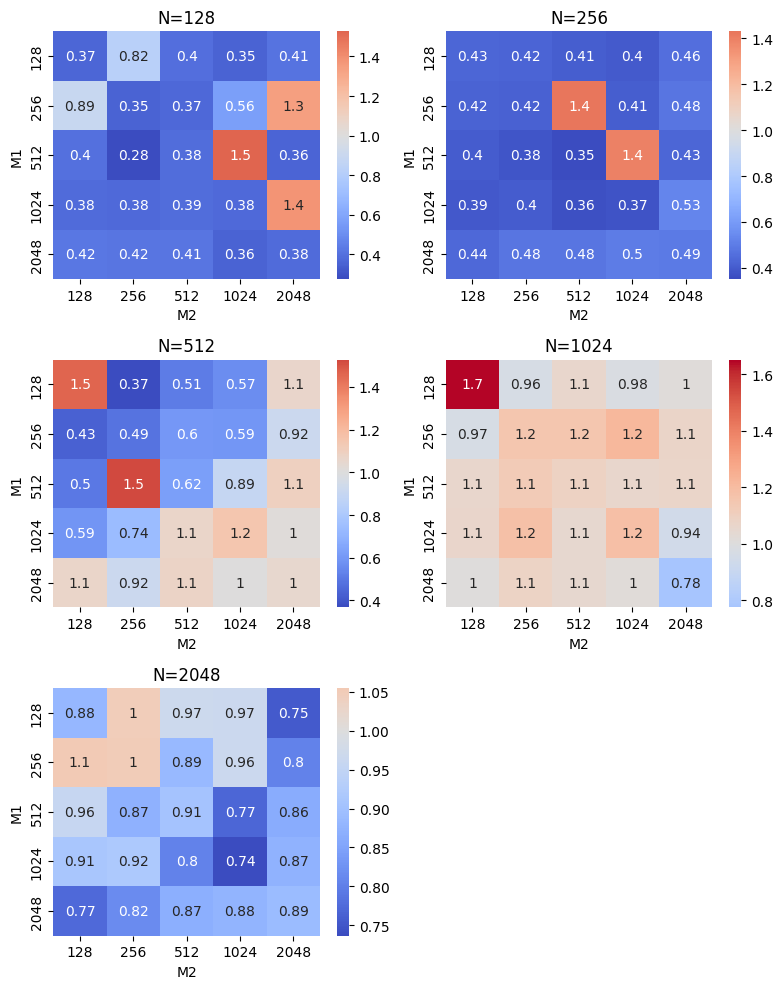

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.DataFrame.from_dict(results)
df["diff"] = df["torch"] / df["triton"]
plt.figure(figsize=(8, 10))
for i, N in enumerate([128, 256, 512, 1024, 2048]):
    plt.subplot(3, 2, i + 1)
    sns.heatmap(df[df["N"] == N].pivot(index="M1", columns="M2", values="diff"), annot=True, cmap="coolwarm", center=1)
    plt.title(f"N={N}")
plt.tight_layout()

100%|██████████| 5/5 [00:15<00:00,  3.18s/it]


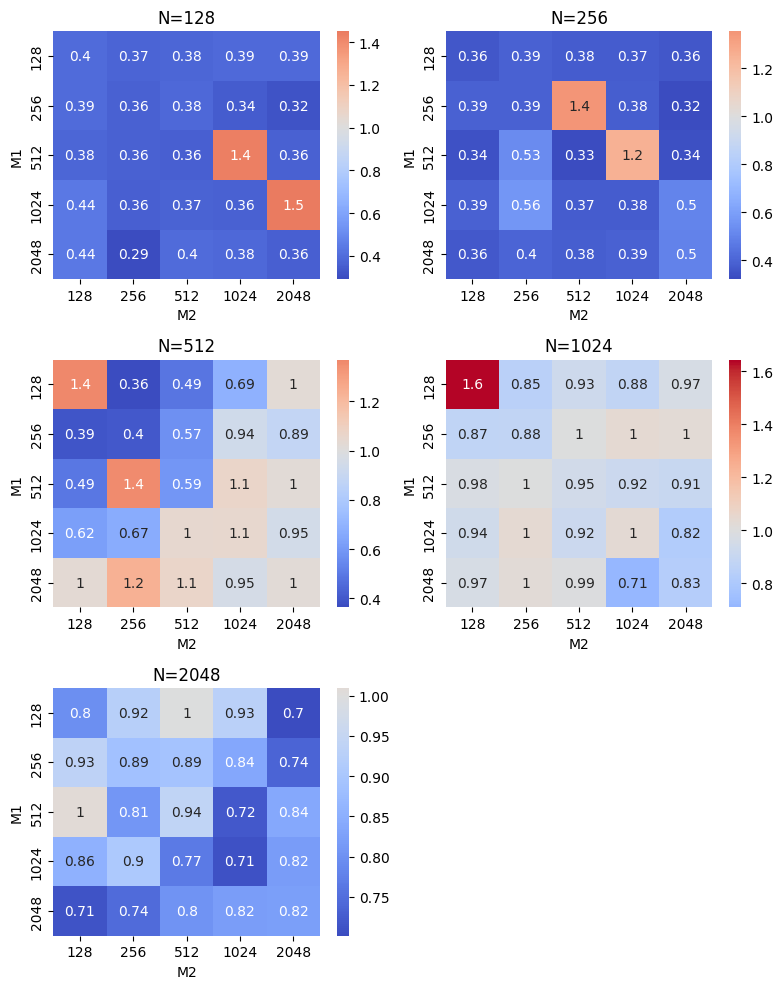

In [7]:
from itertools import product
from tqdm import tqdm
import pandas as pd
results = []
for N in tqdm([128, 256, 512, 1024, 2048]):
    for M1 in [128, 256, 512, 1024, 2048]:
        for M2 in [128, 256, 512, 1024, 2048]:
            to, tr = measure(M1, M2, N, N)
            results.append({
                "N": N, 
                "M1": M1,
                "M2": M2,
                "triton": tr,
                "torch": to
            })

import seaborn as sns
import matplotlib.pyplot as plt
df = pd.DataFrame.from_dict(results)
df["diff"] = df["torch"] / df["triton"]
plt.figure(figsize=(8, 10))
for i, N in enumerate([128, 256, 512, 1024, 2048]):
    plt.subplot(3, 2, i + 1)
    sns.heatmap(df[df["N"] == N].pivot(index="M1", columns="M2", values="diff"), annot=True, cmap="coolwarm", center=1)
    plt.title(f"N={N}")
plt.tight_layout()

In [1]:
import torch
import torch.nn as nn

# Helper function to inspect
def inspect_saved_tensors(output, title=""):
    grad_fn = output.grad_fn
    if grad_fn is not None:
        saved = getattr(grad_fn, 'saved_tensors', None)
        print(f"--- {title} ---")
        print(f"Grad fn: {grad_fn}")
        if saved:
            print(f"Saved tensors: {[s.shape for s in saved]}")
        else:
            print("No saved tensors.")
    else:
        print(f"--- {title} ---")
        print("No grad_fn (probably requires_grad=False)")

# Create model and input
linear = nn.Linear(5, 3)
x = torch.randn(2, 5, requires_grad=True)

# CASE 1: Normal training mode
out = linear(x)
inspect_saved_tensors(out, title="Training (normal)")

# Now, freeze weights
linear.weight.requires_grad_(False)
linear.bias.requires_grad_(False)

# CASE 2: After freezing parameters
out_frozen = linear(x)
inspect_saved_tensors(out_frozen, title="Training (frozen params)")

# Optional: Also test inside torch.no_grad() (inference mode)
with torch.no_grad():
    out_inference = linear(x)
    inspect_saved_tensors(out_inference, title="Inference (no grad)")

# Backward to trigger gradient flow
loss = out.sum()
loss.backward()

--- Training (normal) ---
Grad fn: <AddmmBackward0 object at 0x7175e07f7f70>
No saved tensors.
--- Training (frozen params) ---
Grad fn: <AddmmBackward0 object at 0x7175e07f7f70>
No saved tensors.
--- Inference (no grad) ---
No grad_fn (probably requires_grad=False)


In [ ]:
import torch.nn as nn
import torch
linear = nn.Linear(5, 5).cuda()
x = torch.randn(2, 5, requires_grad=True, device='cuda')

linear.weight.requires_grad_(False)
linear.bias.requires_grad_(False)

y = linear(linear(x))
import gc

total_memory = 0

for obj in gc.get_objects():
    if torch.is_tensor(obj) and obj.is_cuda:
        size_mb = obj.numel() * obj.element_size() / 1024**2
        print(f"Tensor of shape {obj.shape} uses {size_mb:.2f} MB")
        total_memory += size_mb

print(f"Total memory from tensors: {total_memory:.2f} MB")

Tensor of shape torch.Size([5, 5]) uses 0.00 MB
Tensor of shape torch.Size([5]) uses 0.00 MB
Tensor of shape torch.Size([2, 5]) uses 0.00 MB
Tensor of shape torch.Size([2, 5]) uses 0.00 MB
Total memory from tensors: 0.00 MB


/mnt/home/surkov/conda_envs/venv/lib/python3.10/site-packages/torch/__init__.py:1113: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  return isinstance(obj, torch.Tensor)


In [12]:
import torch
import time

# Setup
torch.manual_seed(0)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

A = torch.randn(64*512, 768, device=device)
B = torch.randn(768, 768, device=device)

def time_fn(fn):
    if device == 'cuda':
        torch.cuda.synchronize()
    start = time.time()
    for _ in range(100):
        fn()
    if device == 'cuda':
        torch.cuda.synchronize()
    end = time.time()
    return end - start


half = 9 * A.shape[0] // 10

def usual():
    XY = A @ B
    return XY[:half], XY[half:]


def split_merge():
    X, Y = A[:half] @ B, A[half:] @ B
    return X, Y

assert torch.allclose(usual()[0], split_merge()[0])

time_split = time_fn(split_merge)
time_full = time_fn(usual)

# Measure full A @ B
time_full = time_fn(usual)

# Measure split A @ B
time_split = time_fn(split_merge)


print(f"Time full: {time_full:.6f} seconds")
print(f"Time split: {time_split:.6f} seconds")

if time_full < time_split:
    print("✅ Full A @ B is faster than splitting.")
else:
    print("⚠️ Splitting is faster (unexpected).")

Time full: 0.207483 seconds
Time split: 0.208952 seconds
✅ Full A @ B is faster than splitting.


In [ ]:
class MixedLinearFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input_grad, weight):
        ctx.save_for_backward(input_grad, weight)
        output_grad = input_grad @ weight
        with torch.no_grad():
            output_nograd = input_nograd @ weight
        return output_grad, (output_nograd,)
    
    @staticmethod
    def backward(ctx, grad_output, _):
        input, weight = ctx.saved_tensors
        assert _ is None, "The second grad_output should be None because output_nograd requires no grad"
        
        grad_input = grad_output @ weight.T
        grad_weight = input.transpose(1, 2) @ grad_output
        grad_weight = grad_weight.sum(dim=0)
        
        return grad_input, None, grad_weight

class MixedLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super(MixedLinear, self).__init__()
        self.weight = nn.Parameter(torch.randn(in_features, out_features))
        
    def forward(self, input_grad, input_nograd):
        return MixedLinearFunction.apply(input_grad, input_nograd, self.weight)